# Tải Dữ liệu

In [1]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", data_dir)

Path to dataset files: /home/nico/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


# Import Các Thư Viện Cần Thiết

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Set the random seed for reproducibility.
seed = 123
torch.manual_seed(seed)

# Định Nghĩa Class Dataset

In [3]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(
                        f"Image {img_name} has multiple objects and will be excluded from the dataset"
                    )
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label = self.parse_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        label = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if (
                label is None
            ):  # Take the first label for now. We are working with 1 label per image
                label = name

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num

# Chuẩn Bị Dữ Liệu

In [4]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


# Xây Dựng Mô Hình

In [5]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Vòng Lặp Huấn Luyện Mô Hình

In [8]:
# Training Loop
num_epochs = 10
for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    for batch_idx, (data, targets) in enumerate(tqdm.tqdm(train_loader, desc="Training", leave=False)):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in tqdm.tqdm(val_loader, desc="Validation", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/10, Validation Accuracy: 96.34%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/10, Validation Accuracy: 94.04%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/10, Validation Accuracy: 96.07%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/10, Validation Accuracy: 96.07%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/10, Validation Accuracy: 94.85%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/10, Validation Accuracy: 95.80%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/10, Validation Accuracy: 93.50%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/10, Validation Accuracy: 95.93%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/10, Validation Accuracy: 96.34%


Training:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/10, Validation Accuracy: 97.29%


# Biểu diễn dự đoán model

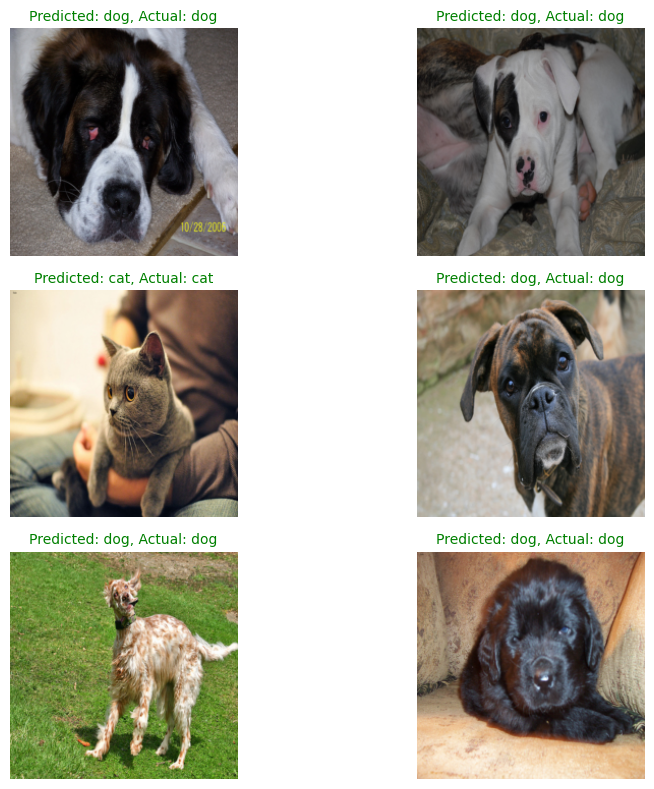

In [16]:
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    class_names = ["cat", "dog"]
    fig = plt.figure(figsize=(10, 8))

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"Predicted: {class_names[preds[j]]}, Actual: {class_names[labels[j]]}",
                    fontdict={
                        "fontsize": 10,
                        "color": "green" if preds[j] == labels[j] else "red",
                    },
                )
                # Denormalize and display the image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.tight_layout()
                    return


visualize_predictions(model, val_loader)
plt.show()

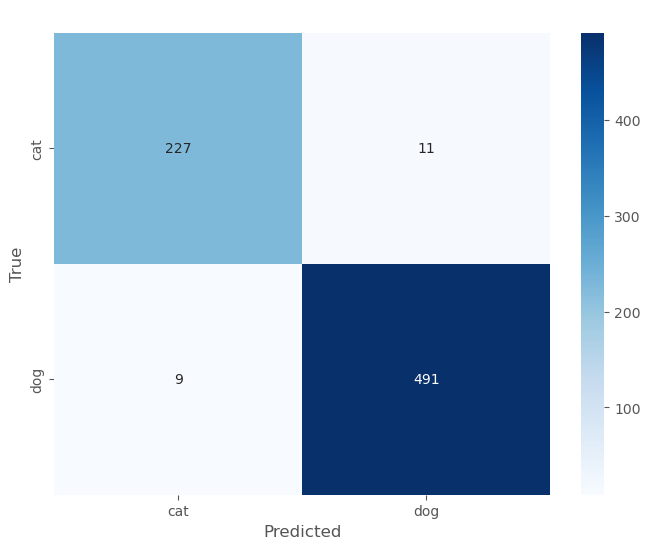

In [17]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_loader)